In [6]:
from pathlib import Path
import os
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from pydidas.core import Dataset
from pydidas.data_io import import_data
%matplotlib inline


import importlib
import sys

from dataclasses import dataclass
from scipy.optimize import curve_fit

from pydidas.core.constants import PROC_PLUGIN, PROC_PLUGIN_INTEGRATED
from pydidas.plugins import ProcPlugin


fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/sin2chi_grouping.py'
spec = importlib.util.spec_from_file_location('sin2chi_grouping', fname)
sin2chi_grouping = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sin2chi_grouping)

# Check if the module object is created
if hasattr(sin2chi_grouping, '__file__'):
    print("Module was successfully loaded.")

# Inspect module attributes
print("Module attributes:", dir(sin2chi_grouping))

#We need to append the path to the sys.path to import the module
sys.path.append('/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins')

from sin2chi_grouping import Labels, Units, Tolerance, Category, DictViaAttrs, DspacingSin2chiGrouping

Module was successfully loaded.
Module attributes: ['Category', 'Dataset', 'Dict', 'DictViaAttrs', 'DspacingSin2chiGrouping', 'Enum', 'IntEnum', 'Labels', 'List', 'PROC_PLUGIN', 'PROC_PLUGIN_INTEGRATED', 'ProcPlugin', 'StrEnum', 'Tolerance', 'Tuple', 'Units', '__all__', '__author__', '__builtins__', '__cached__', '__copyright__', '__doc__', '__file__', '__license__', '__loader__', '__maintainer__', '__name__', '__package__', '__spec__', '__status__', 'connected_components', 'csr_matrix', 'np']


input_shape None
result_shape None
input_data None
_dict {'_chi_key': None, '_pos_key': None, '_pos_idx': None, '_s2c_labels': None, '_n_components': None}
_chi_key None
_pos_key None
_pos_idx None
_s2c_labels None
_n_components None
Chi
 [-180 -179 -178 -177 -176 -175 -174 -173 -172 -171 -170 -169 -168 -167
 -166 -165 -164 -163 -162 -161 -160 -159 -158 -157 -156 -155 -154 -153
 -152 -151 -150 -149 -148 -147 -146 -145 -144 -143 -142 -141 -140 -139
 -138 -137 -136 -135 -134 -133 -132 -131 -130 -129 -128 -127 -126 -125
 -124 -123 -122 -121 -120 -119 -118 -117 -116 -115 -114 -113 -112 -111
 -110 -109 -108 -107 -106 -105 -104 -103 -102 -101 -100  -99  -98  -97
  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87  -86  -85  -84  -83
  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69
  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55
  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41
  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31 

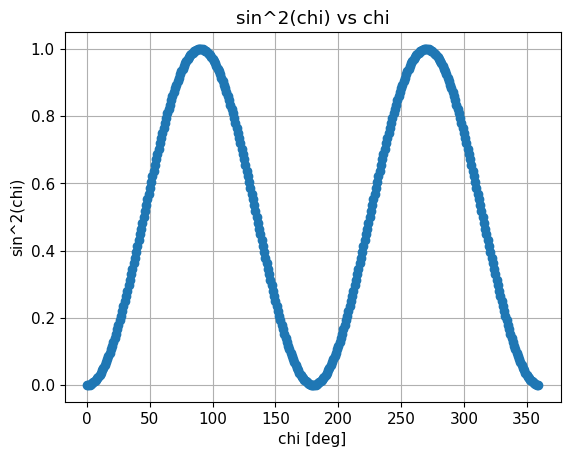

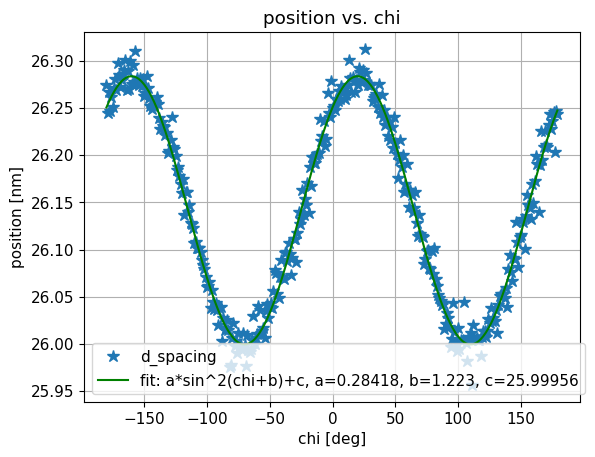

🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓
d_spacing shape (360,)
s2c_labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 89 88 87 86 85
 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61
 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37
 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73
 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 5

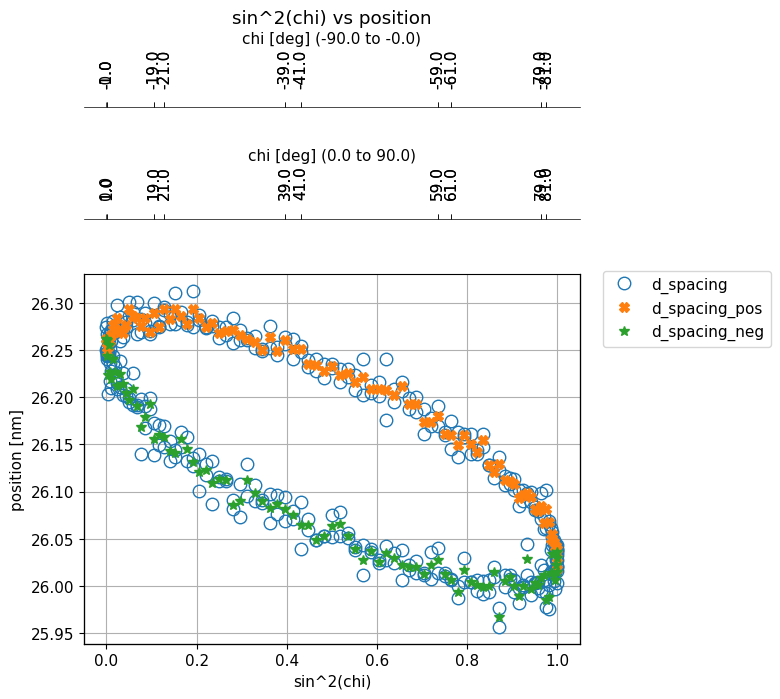

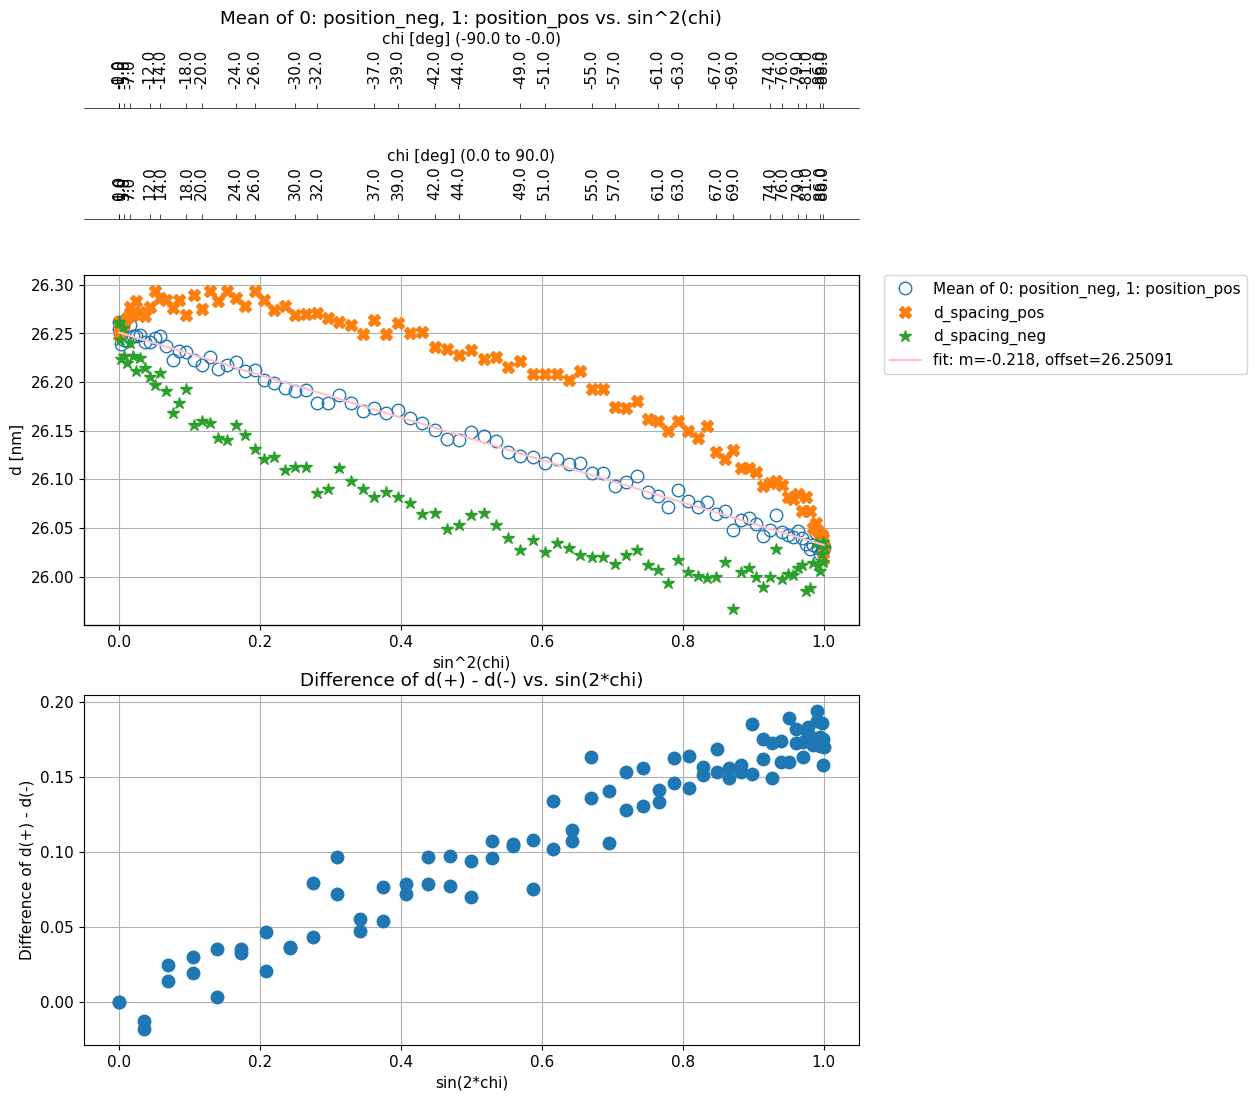

In [12]:
@dataclass
class Real_Dataset_Info:
    path: Path
    fname: str
    
    def fpath(self) -> Path:
        return self.path / Path(self.fname)
    
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def plot_sin2chi(chi):
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, linestyle='None', marker='o')
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs chi')
    ax.grid()
    fig.show()

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  


def plot_d_spacing_vs_chi_1d(ds, chi, scan_axis):
    
    print('ds.shape:', ds.shape)
    
    chi_key, (pos_key, pos_idx)  = chi_pos_verification(ds)
    
    fig, ax = plt.subplots()
    
    for pos in ds.axis_ranges[scan_axis]:
        # Extract d_spacing for the specific position
        d_spacing = ds[pos, :, ]
   

def plot_d_spacing_vs_chi_2d_2d(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """

    print('ds.shape:', ds.shape)
    
    fig, ax = plt.subplots()
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs chi for various x,y')
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict


def plot_d_spacing_vs_sin2chi_fit(chi, ds, d_spacing, units, pos_key, pos_idx, chi_key):
    
    d_spacing_low=np.min(d_spacing.array)
    popt, pcov = curve_fit(sin2_fit, chi, d_spacing,maxfev=100000, sigma=0.001*np.ones(chi.shape), absolute_sigma=False, bounds=((0, -2, d_spacing_low-0.5),(1, 2, d_spacing_low+0.5)))
    a_fit=popt[0]
    b_fit=popt[1]
    c_fit=popt[2]
    axis_labels_dict = split_fit_labels(ds.axis_labels[pos_key])
    fig, ax = plt.subplots()
    ax.plot(chi, d_spacing, linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.plot(chi, sim_sin2(chi, a_fit, b_fit, c_fit), color='green', label=f'fit: a*sin^2(chi+b)+c, a={a_fit:.5f}, b={b_fit:.3f}, c={c_fit:.5f}')
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{ds.axis_labels[chi_key]} [{ds.axis_units[chi_key]}]')    
    ax.set_title(f'{axis_labels_dict[pos_idx]} vs. {ds.axis_labels[chi_key]}')
    ax.grid()
    plt.legend()
    plt.show()


    
def plot_d_spacing_pos_neg(chi, ds, d_spacing, d_spacing_pos, d_spacing_neg, units, pos_idx, pos_key):
    
    axis_labels_dict = split_fit_labels(ds.axis_labels[pos_key])
    
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{d_spacing_pos.axis_labels[0]}')
    ax.set_title(f'{d_spacing_pos.axis_labels[0]} vs {axis_labels_dict[pos_idx]}')
    
    add_chi_axes(ax, chi, fig)
    #interval = 4
    #x_index = np.arange(0, len(chi), interval)
    #ax2top=ax.twiny()
    #ax2top.set_xlim(ax.get_xlim())
    #formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    #ax2top.set_xticks(x_index)
    #ax2top.set_xticklabels(formatted_labels)
    #ax2top.set_xlabel('chi [deg]')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.03))
    ax.grid()
    fig.show()
    
    
def plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi):
    
    mask = ~np.isnan(d_spacing_avg.array)
    x_data_filtered = d_spacing_avg.axis_ranges[0][mask]
    y_data_filtered = d_spacing_avg.array[mask]
    
    popt_reg_fit, pcov_reg_fit = curve_fit(regression_line_fit, x_data_filtered, y_data_filtered, maxfev=100000, sigma=0.001*np.ones(y_data_filtered.shape), absolute_sigma=False)    
    m_fit=popt_reg_fit[0]
    offset_fit=popt_reg_fit[1]
       
    
    
    import matplotlib.gridspec as gridspec
    # Create a GridSpec with explicit height ratios
    fig = plt.figure(figsize=(10, 10))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.2)  # Increase hspace for more vertical space

    # Create the subplots using ax[0] and ax[1]
    ax = [None, None]
    ax[0] = fig.add_subplot(gs[0])
    ax[1] = fig.add_subplot(gs[1])
    
    ax[0].plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label=f'{d_spacing_avg.data_label}', markerfacecolor='None', markersize=9)
    ax[0].plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=8)
    ax[0].plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=9)
    ax[0].plot(d_spacing_avg.axis_ranges[0], sim_regression_line(d_spacing_avg.axis_ranges[0], m_fit, offset_fit), color='pink', label=f'fit: m={m_fit:.3f}, offset={offset_fit:.5f}')
    ax[0].set_ylabel(f'd [{d_spacing_avg.data_unit}]')
    ax[0].set_xlabel(d_spacing_avg.axis_labels[0])
    ax[0].set_title(f'{d_spacing_avg.data_label} vs. {d_spacing_avg.axis_labels[0]}') #'sin^2(chi) vs d_spacing
    #interval = 4
    #x_index = np.arange(0, len(chi), interval)
    #ax2top=ax[0].twiny()
    #ax2top.set_xlim(ax[0].get_xlim())
    #formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    #ax2top.set_xticks(x_index)
    #ax2top.set_xticklabels(formatted_labels)
    #ax2top.set_xlabel('chi [deg]')
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.51, 1.02))
    
    add_chi_axes(ax[0], chi, fig)
    
    ax[0].grid()
    
    ax[1].plot(d_spacing_diff.axis_ranges[0], d_spacing_diff.array, linestyle='None', marker='o', label=d_spacing_diff.data_label, markersize=9)
    ax[1].set_title(f'{d_spacing_diff.data_label} vs. {d_spacing_diff.axis_labels[0]}')
    ax[1].set_xlabel(f'{d_spacing_diff.axis_labels[0]}')
    ax[1].set_ylabel(f'{d_spacing_diff.data_label}')
    ax[1].grid()
    # Adjust the space between the subplots
    fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space    
    fig.show() 
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict

  
def sin2_fit(chi, a, b,c ):
    return a*np.sin(np.deg2rad(chi)+b)**2+c  

def sim_sin2(chi, a, b,c):
    return a*np.sin(np.deg2rad(chi)+b)**2+c

def regression_line_fit(s2c, m, offset):
    return m*s2c + offset

def sim_regression_line(s2c, m, offset):
    return m*s2c + offset


def add_chi_axes(ax, chi, fig):
    """
    Add two top x-axes to the given axes: one for positive chi and one for negative chi.
    Dynamically adjust the number of labels based on the figure width and avoid label overlap.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the top x-axes will be added.
        chi (np.ndarray): The chi values in degrees.
        fig (matplotlib.figure.Figure): The figure containing the axes.
    """
    
    # Calculate sin^2(chi)
    sin2_chi = np.sin(np.deg2rad(chi))**2
    
    # Calculate the number of labels to display based on figure width
    fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
    num_labels = max(5, int(fig_width * 3))  # Adjust this factor as needed

    # Create top x-axis for chi_positive
    ax2top_pos = ax.twiny()
    ax2top_pos.set_xlim(ax.get_xlim())
    
    # Position the second top x-axis slightly outward
    ax2top_pos.spines['top'].set_position(('outward', 40))  # Adjust this value for proper spacing
    ax2top_pos.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Calculate the corresponding chi values from sin^2(chi)
    chi_positive = np.rad2deg(np.arcsin(np.sqrt(sin2_chi)))

    # Select a subset of chi values to display
    indices = np.linspace(0, len(chi_positive) - 1, num_labels, dtype=int)

    # Ensure the tick positions are within the x-axis limits
    ticks_pos = np.clip(sin2_chi[indices], ax.get_xlim()[0], ax.get_xlim()[1])
    labels_pos = [f'{val:.1f}' for val in chi_positive[indices]]
    
    # Set the ticks and labels for chi_positive
    ax2top_pos.set_xticks(ticks_pos)
    ax2top_pos.set_xticklabels(labels_pos)

    # Dynamic label for chi_positive
    chi_pos_min = np.min(chi_positive)
    chi_pos_max = np.max(chi_positive)
    ax2top_pos.set_xlabel(f'chi [deg] ({chi_pos_min:.1f} to {chi_pos_max:.1f})')

    # Create another top x-axis for chi_negative
    ax2top_neg = ax.twiny()
    ax2top_neg.set_xlim(ax.get_xlim())
    
    # Move the second top axis further outward
    ax2top_neg.spines['top'].set_position(('outward', 120))  # Further outward than ax2top_pos
    ax2top_neg.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Calculate the corresponding negative chi values (-180 to -90)
    chi_negative = np.rad2deg(np.arcsin(-np.sqrt(sin2_chi)))

    # Select a subset of negative chi values to display
    indices_neg = np.linspace(0, len(chi_negative) - 1, num_labels, dtype=int)

    # Ensure the tick positions are within the x-axis limits
    ticks_neg = np.clip(sin2_chi[indices_neg], ax.get_xlim()[0], ax.get_xlim()[1])
    labels_neg = [f'{val:.1f}' for val in chi_negative[indices_neg]]
    
    # Set the ticks and labels for chi_negative
    ax2top_neg.set_xticks(ticks_neg)
    ax2top_neg.set_xticklabels(labels_neg)

    # Dynamic label for chi_negative
    chi_neg_min = np.min(chi_negative)
    chi_neg_max = np.max(chi_negative)
    ax2top_neg.set_xlabel(f'chi [deg] ({chi_neg_min:.1f} to {chi_neg_max:.1f})')

    # Adjust label rotation and alignment to prevent overlap
    for label in ax2top_pos.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    for label in ax2top_neg.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    # Adjust spacing between labels and axis
    ax2top_pos.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding
    ax2top_neg.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding

    
def create_dummy_dataset(delta_chi, chi_start, chi_stop, phase_shift, spatial_var=False):
       
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
    
    plot_sin2chi(chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #make up data label 
    data_labels= 'position / nm; area / (cts * nm); FWHM / nm;background at peak / cts; total count intensity / cts'
    
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
   
    result_array= generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=spatial_var, phase_shift=phase_shift)
    
    print('Result array shape\n', result_array.shape)
    ds = Dataset(result_array,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
         
    return (chi, ds)

def main():
    plugin=DspacingSin2chiGrouping(stress_strain_config=DictViaAttrs(dict()))
    plugin.pre_execute()
    for key, value in plugin.config._dict.items():
        print(key, value)
    
    chi, ds = create_dummy_dataset(delta_chi=1, chi_start=-180, chi_stop=180, phase_shift=70, spatial_var=False)
    x_idx=3
    y_idx=4
       
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
    
    # slice Dataset based on location
    ds1 = ds[x_idx, y_idx]
    #Introducing seed and random noise for d_spacing
    ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
    
    chi, d_spacing = plugin._ds_slicing(ds1) 
    d_spacing_pos, d_spacing_neg=plugin._group_d_spacing_by_chi(d_spacing, chi)
    d_spacing_combined = plugin._combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    d_spacing_avg, d_spacing_diff = plugin._pre_regression_calculation(d_spacing_combined) 
    
    
    plot_d_spacing_vs_sin2chi_fit(chi, ds1, d_spacing, units=plugin._extract_units(ds1), pos_key=plugin.config._pos_key, pos_idx=plugin.config._pos_idx, 
                                  chi_key=plugin.config._chi_key)
    
    
    plot_d_spacing_pos_neg(chi, ds1, d_spacing, d_spacing_pos, d_spacing_neg, units=plugin._extract_units(ds1), pos_idx=plugin.config._pos_idx, pos_key=plugin.config._pos_key)
    
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi)
    
    print(30*"\N{strawberry}")
    print('d_spacing shape', d_spacing.shape)
    print('s2c_labels', plugin.config._s2c_labels)
    print('Length of s2c_labels', len(plugin.config._s2c_labels))
    print('Unique s2c_labels', np.unique(plugin.config._s2c_labels))
    print('Length of unique s2c_labels', len(np.unique(plugin.config._s2c_labels)))
    print('d_spacing_pos shape', d_spacing_pos.shape)
    print('d_spacing_neg shape', d_spacing_neg.shape)
    print('d_spacing_combined shape', d_spacing_combined.shape)
    print('d_spacing_avg shape', d_spacing_avg.shape)
    print('d_spacing_diff shape', d_spacing_diff.shape)
    
    print(40*"\N{Cherries}")
    
    def create_final_result(d_spacing_combined, d_spacing_avg, d_spacing_diff):
        print('d_spacing_combined\n',d_spacing_combined )
        print('d_spacing_avg\n',d_spacing_avg )
        print('d_spacing_diff\n',d_spacing_diff )
        
        
        
        
    
    create_final_result(d_spacing_combined, d_spacing_avg, d_spacing_diff)


if __name__ == "__main__":
    main()